# 02 — Exploratory Data Analysis

Loads the processed panel and produces summary statistics and figures saved to `outputs/figures/`.

In [9]:
import sys, platform
import pandas as pd
import numpy as np

print("python:", sys.version.split()[0])
print("platform:", platform.platform())
print("pandas:", pd.__version__)
print("numpy:", np.__version__)

python: 3.12.9
platform: Windows-11-10.0.26200-SP0
pandas: 2.3.3
numpy: 2.3.5


In [10]:
from pathlib import Path
import pandas as pd

# =====================================================
# Repo + load processed panel
# =====================================================

START = Path.cwd().resolve()

def find_repo(start: Path) -> Path:
    roots = [start]
    if start.drive:
        roots.append(Path(start.drive + "\\") / "projects")

    required = ["state_year_panel.parquet"]
    seen = set()
    for root in roots:
        root = root.resolve()
        if root in seen or not root.exists():
            continue
        seen.add(root)
        for proc_dir in root.rglob("data/processed"):
            if all((proc_dir / f).exists() for f in required):
                return proc_dir.parent.parent  # .../data/processed -> repo root
    raise RuntimeError(f"Could not find repo root from start={start}")

REPO = find_repo(START)
PROCESSED = REPO / "data" / "processed"
PANEL_PATH = PROCESSED / "state_year_panel.parquet"

panel = pd.read_parquet(PANEL_PATH)

print("CWD:", START)
print("Repo:", REPO)
print("Loaded panel:", panel.shape)
display(panel.head())

CWD: C:\projects\python-policy-project\notebooks
Repo: C:\projects\python-policy-project
Loaded panel: (1581, 7)


,state,state_name,state_fips,year,poverty_rate,median_income,unemployment_rate
0,AK,Alaska,02,1989,10.6,33885,7.1
1,AK,Alaska,02,1993,11.2,39431,7.8
2,AK,Alaska,02,1995,10.1,42255,7.3
3,AK,Alaska,02,1996,10.6,44797,7.5
4,AK,Alaska,02,1997,11.2,43657,7.0


In [11]:
# Quick descriptive stats
desc = panel[["poverty_rate", "median_income", "unemployment_rate"]].describe().T
display(desc)

print("States per year (tail):")
print(panel.groupby("year")["state"].nunique().tail())

,count,mean,std,min,25%,50%,75%,max
poverty_rate,1581.0,13.035990,3.271190,5.6,10.5,12.5,15.3,24.6
median_income,1581.0,50108.850727,14829.957578,19874.0,39571.0,47524.0,58906.0,104643.0
unemployment_rate,1581.0,5.280835,1.908656,1.8,3.9,5.0,6.3,13.5


States per year (tail):
year
2019    51
2020    51
2021    51
2022    51
2023    51
Name: state, dtype: int64


Saving figures to: C:\projects\python-policy-project\reports\figures


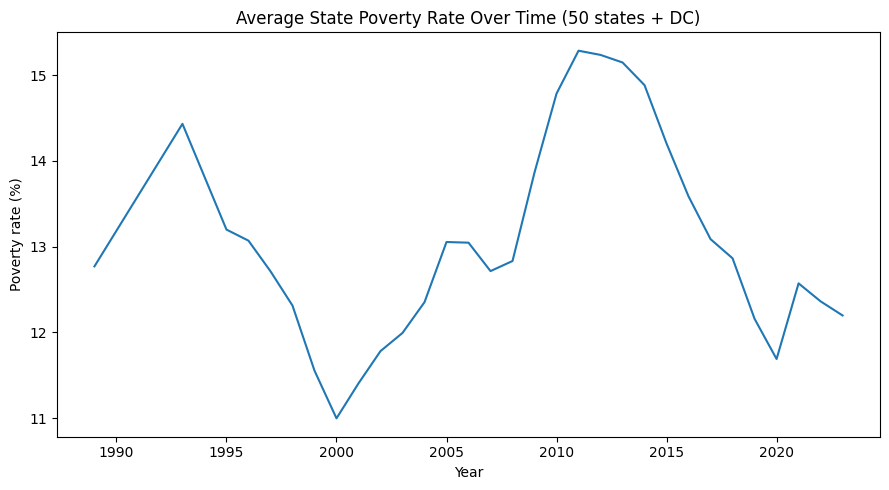

Saved: C:\projects\python-policy-project\reports\figures\trend_poverty_rate.png


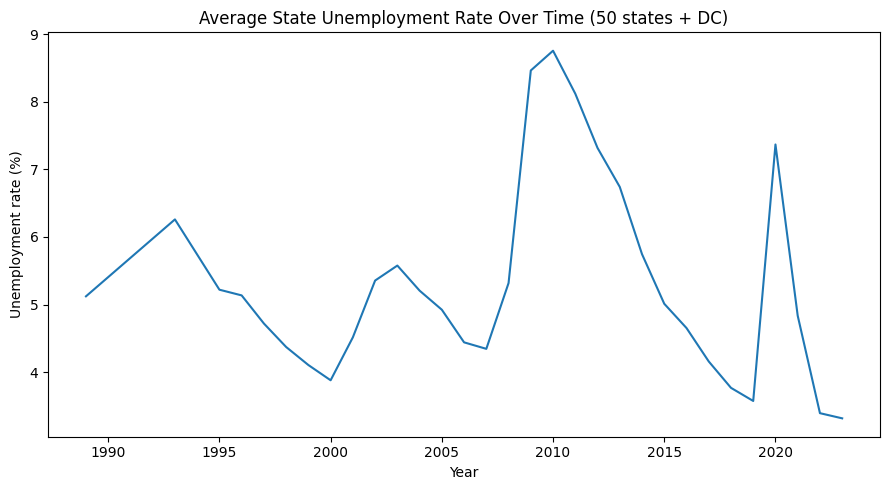

Saved: C:\projects\python-policy-project\reports\figures\trend_unemployment_rate.png


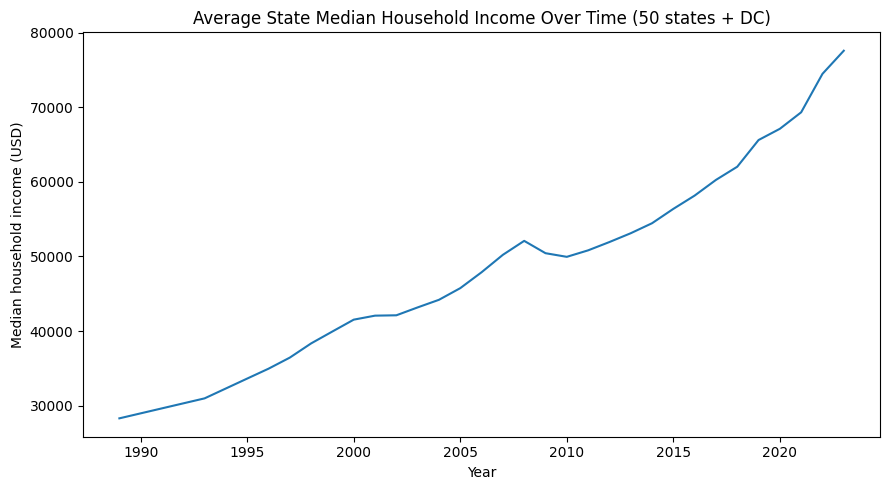

Saved: C:\projects\python-policy-project\reports\figures\trend_median_income.png
Cross-section year: 2023 | rows: 51


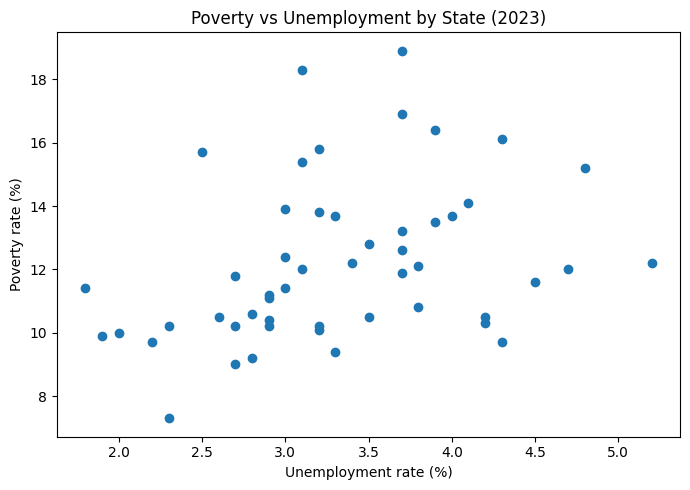

Saved: C:\projects\python-policy-project\reports\figures\scatter_poverty_vs_unemployment_2023.png


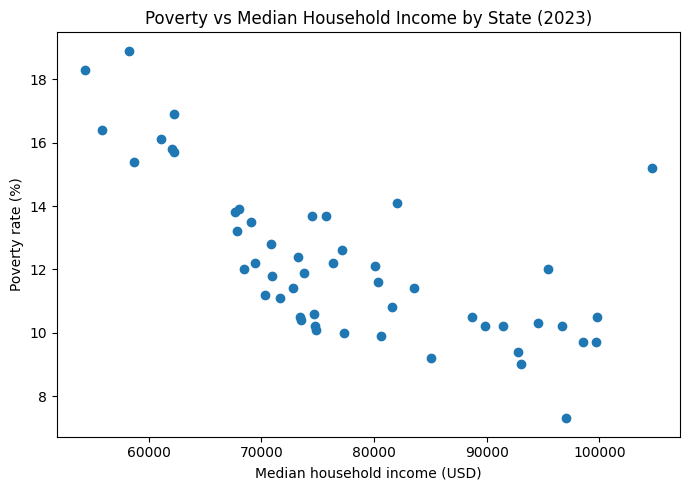

Saved: C:\projects\python-policy-project\reports\figures\scatter_poverty_vs_income_2023.png


In [12]:
import matplotlib.pyplot as plt
from pathlib import Path

FIG_DIR = REPO / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)
print("Saving figures to:", FIG_DIR)

# --- National (average state) trends over time ---
us = (
    panel.groupby("year", as_index=False)[["poverty_rate", "median_income", "unemployment_rate"]]
    .mean()
    .sort_values("year")
)

plt.figure(figsize=(9, 5))
plt.plot(us["year"], us["poverty_rate"])
plt.xlabel("Year")
plt.ylabel("Poverty rate (%)")
plt.title("Average State Poverty Rate Over Time (50 states + DC)")
plt.tight_layout()
out = FIG_DIR / "trend_poverty_rate.png"
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)

plt.figure(figsize=(9, 5))
plt.plot(us["year"], us["unemployment_rate"])
plt.xlabel("Year")
plt.ylabel("Unemployment rate (%)")
plt.title("Average State Unemployment Rate Over Time (50 states + DC)")
plt.tight_layout()
out = FIG_DIR / "trend_unemployment_rate.png"
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)

plt.figure(figsize=(9, 5))
plt.plot(us["year"], us["median_income"])
plt.xlabel("Year")
plt.ylabel("Median household income (USD)")
plt.title("Average State Median Household Income Over Time (50 states + DC)")
plt.tight_layout()
out = FIG_DIR / "trend_median_income.png"
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)

# --- Cross-sectional scatter for latest year ---
YEAR = int(panel["year"].max())
cs = panel.loc[panel["year"] == YEAR, ["state", "poverty_rate", "median_income", "unemployment_rate"]].dropna()
print("Cross-section year:", YEAR, "| rows:", cs.shape[0])

plt.figure(figsize=(7, 5))
plt.scatter(cs["unemployment_rate"], cs["poverty_rate"])
plt.xlabel("Unemployment rate (%)")
plt.ylabel("Poverty rate (%)")
plt.title(f"Poverty vs Unemployment by State ({YEAR})")
plt.tight_layout()
out = FIG_DIR / f"scatter_poverty_vs_unemployment_{YEAR}.png"
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)

plt.figure(figsize=(7, 5))
plt.scatter(cs["median_income"], cs["poverty_rate"])
plt.xlabel("Median household income (USD)")
plt.ylabel("Poverty rate (%)")
plt.title(f"Poverty vs Median Household Income by State ({YEAR})")
plt.tight_layout()
out = FIG_DIR / f"scatter_poverty_vs_income_{YEAR}.png"
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)

## Interpretation & Limitations

- Estimates are descriptive and not causal
- Results are sensitive to time controls
- State aggregation masks within-state heterogeneity